# Import Library

In [1]:
# For data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

# For model, tokenizer
import transformers
from transformers import AutoTokenizer, AutoConfig, T5ForConditionalGeneration

# For neccessary
import os
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

# Load CSV

In [2]:
train_df = pd.read_csv("/kaggle/input/skinchat-qa/skinchat_train.csv")
valid_df = pd.read_csv("/kaggle/input/skinchat-qa/skinchat_valid.csv")
test_df = pd.read_csv("/kaggle/input/skinchat-qa/skinchat_test.csv")

In [3]:
train_df.shape, valid_df.shape, test_df.shape

((220697, 2), (130, 2), (130, 2))

# Change formats

In [4]:
def change_format_df(df):
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    df = df.rename(columns={"Question":"source_text","Answer":"target_text"})
    df["source_text"] = "Trả lời câu hỏi này: " + df["source_text"].str.replace("\n","<newline>")
    df["target_text"] = df["target_text"].str.replace("\n","<newline>")
    return df

In [5]:
train_df = change_format_df(train_df)
valid_df = change_format_df(valid_df)
test_df = change_format_df(test_df)

# Training new T5 Tokenizer

In [6]:
MODEL_NAME = "t5-base"
MAX_VOCAB = 20000

In [7]:
df = pd.concat([train_df, test_df, valid_df]).reset_index(drop=True)
def get_data_for_training_tokenizer():
    text = ""
    for i in tqdm(range(df.shape[0]), desc="Training Tokenizer"):
        if df.shape[0] % (i+1) <= 3:
            yield text
            text = ""
        else:
            text += df["source_text"].iloc[i] + " " + df["target_text"].iloc[i]
    return text

In [8]:
old_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
new_tokenizer = old_tokenizer.train_new_from_iterator(get_data_for_training_tokenizer(), MAX_VOCAB)
new_tokenizer.add_tokens(["<newline>"])

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Training Tokenizer:   0%|          | 0/220957 [00:00<?, ?it/s]

1

In [9]:
print("Old Tokenizer vocab size:",str(old_tokenizer.vocab_size))
print("New Tokenizer vocab size:",str(new_tokenizer.vocab_size))

Old Tokenizer vocab size: 32100
New Tokenizer vocab size: 20000


In [10]:
input_text = "Chào bạn, những triệu chứng bạn mô tả như mụn \nHãy đến gặp bác sĩ nhé"
print("Input text:", input_text)
print("Old Tokenizer- Encoded & Decoded:", old_tokenizer.decode(old_tokenizer.encode(input_text, return_tensors="pt")[0], skip_special_tokens=False))
print("New Tokenizer- Encoded & Decoded:", new_tokenizer.decode(new_tokenizer.encode(input_text.replace("\n","<newline>"), return_tensors="pt")[0], skip_special_tokens=False).replace("<newline>","\n"))

Input text: Chào bạn, những triệu chứng bạn mô tả như mụn 
Hãy đến gặp bác sĩ nhé
Old Tokenizer- Encoded & Decoded: Chào b<unk>n, nh<unk>ng tri<unk>u ch<unk>ng b<unk>n mô t<unk> nh<unk> m<unk>n H<unk>y <unk>n g<unk>p bác s<unk> nhé</s>
New Tokenizer- Encoded & Decoded: Chào bạn, những triệu chứng bạn mô tả như mụn
 Hãy đến gặp bác sĩ nhé</s>


In [11]:
# Save
new_tokenizer.save_pretrained("/kaggle/working/skinchat_tokenizer")

('/kaggle/working/skinchat_tokenizer/tokenizer_config.json',
 '/kaggle/working/skinchat_tokenizer/special_tokens_map.json',
 '/kaggle/working/skinchat_tokenizer/tokenizer.json')

# Data Analysis

In [12]:
df['length_source_text'] = df['source_text'].apply(lambda x: len(new_tokenizer.encode(x, return_tensors="pt")[0]))
df['length_target_text'] = df['target_text'].apply(lambda x: len(new_tokenizer.encode(x, return_tensors="pt")[0]))

In [13]:
df.head(5)

,source_text,target_text,length_source_text,length_target_text
0,Trả lời câu hỏi này: Nấm móng có thể xuất hiện...,"Ngoài móng tay và móng chân, nấm móng có thể l...",25,26
1,Trả lời câu hỏi này: Tôi đã từng phải điều trị...,"Có, nếu bạn đã từng điều trị hội chứng Lyell, ...",27,38
2,Trả lời câu hỏi này: Có trường hợp nào vảy phấ...,Không có trường hợp nào vảy phấn dạng lichen l...,20,23
3,"Trả lời câu hỏi này: Dạ, em không dị ứng với g...",Em có thể cho bác sĩ xem những nốt mẩn đỏ đó đ...,16,26
4,Trả lời câu hỏi này: Tôi bị nghi ngờ nhiễm nấ...,"Có thể, bạn có thể gặp khó chịu, sưng, kích ứn...",31,22


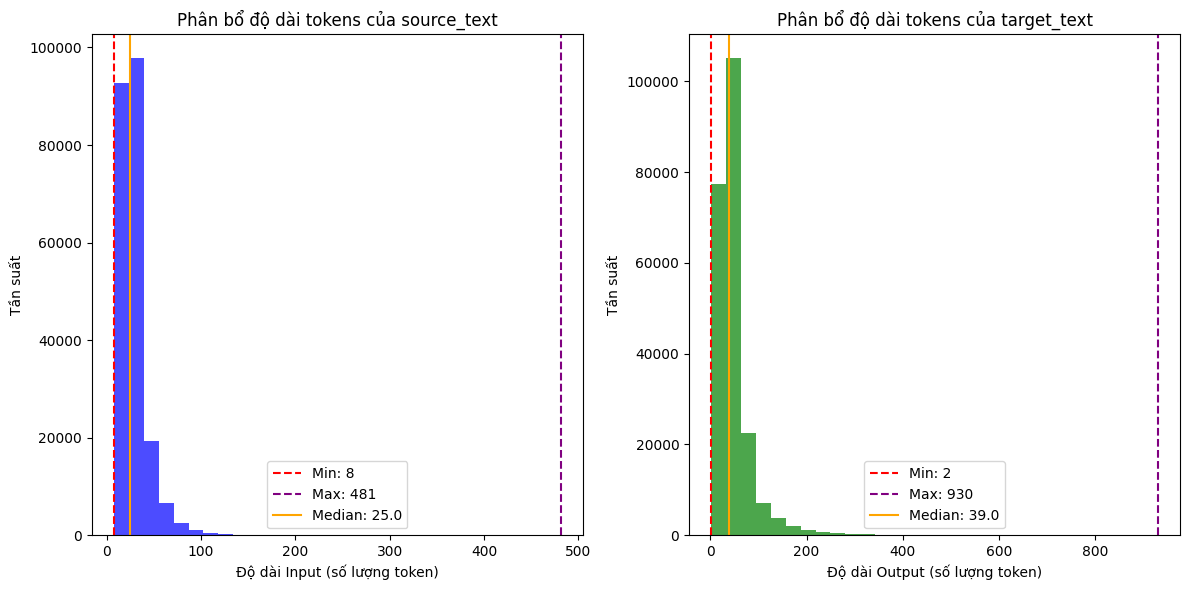

In [14]:
def distribution_plot(df):
    input_min, input_max, input_median = df["length_source_text"].min(), df["length_source_text"].max(), df["length_source_text"].median()
    output_min, output_max, output_median = df["length_target_text"].min(), df["length_target_text"].max(), df["length_target_text"].median()

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(df["length_source_text"], bins=30, color='blue', alpha=0.7)
    plt.axvline(input_min, color='red', linestyle='--', label=f'Min: {input_min}')
    plt.axvline(input_max, color='purple', linestyle='--', label=f'Max: {input_max}')
    plt.axvline(input_median, color='orange', linestyle='-', label=f'Median: {input_median}')
    plt.title('Phân bổ độ dài tokens của source_text')
    plt.xlabel('Độ dài Input (số lượng token)')
    plt.ylabel('Tần suất')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(df["length_target_text"], bins=30, color='green', alpha=0.7)
    plt.axvline(output_min, color='red', linestyle='--', label=f'Min: {output_min}')
    plt.axvline(output_max, color='purple', linestyle='--', label=f'Max: {output_max}')
    plt.axvline(output_median, color='orange', linestyle='-', label=f'Median: {output_median}')
    plt.title('Phân bổ độ dài tokens của target_text')
    plt.xlabel('Độ dài Output (số lượng token)')
    plt.ylabel('Tần suất')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
distribution_plot(df)

In [15]:
df.describe()

,length_source_text,length_target_text
count,220957.000000,220957.000000
mean,28.940432,48.234874
std,15.660671,38.971018
min,8.000000,2.000000
25%,21.000000,28.000000
50%,25.000000,39.000000
75%,32.000000,55.000000
max,481.000000,930.000000


In [16]:
df[(df["length_target_text"] < 12)]

,source_text,target_text,length_source_text,length_target_text
46,"Trả lời câu hỏi này: Vâng, em cảm ơn BS.",Không có gì. Chúc em mau hết bệnh.,13,11
66,"Trả lời câu hỏi này: Dạ không ạ, chỉ mỗi ở lưn...",Vậy thì bạn bị viêm da tiếp xúc,18,9
74,"Trả lời câu hỏi này: Em chào bác sĩ, em bị nấm...",Chào em,30,3
98,Trả lời câu hỏi này: Em có vết nổi đỏ ở vùng b...,Chào em!,63,3
100,"Trả lời câu hỏi này: Em là nam giới, năm nay 3...",Chào bạn. Bạn bị nổi mẩn đỏ ở đâu?,24,11
...,...,...,...,...
220560,Trả lời câu hỏi này: Bệnh zona có lây qua đườn...,"Không, zona không lây qua đường hô hấp.",16,10
220567,Trả lời câu hỏi này: Ở hà nội nên khám ở viện ...,Bệnh viện Da liễu trung ương em nhé,23,9
220579,"Trả lời câu hỏi này: Bác sĩ ơi, em bị mụn lưng...",Chào em!,57,3
220593,Trả lời câu hỏi này: Trẻ sơ sinh 2 tháng trên ...,Chào em.,35,3


In [17]:
print(f"Số lượng câu trả lời có độ dài tokens dưới 13: {df[(df['length_target_text'] <= 12)].shape[0]}")
print(f"Tỉ lệ: {df[(df['length_target_text'] <= 12)].shape[0] / df.shape[0] * 100}")

Số lượng câu trả lời có độ dài tokens dưới 13: 9001
Tỉ lệ: 4.073643288060573


In [18]:
df[df["length_target_text"] < 12]["source_text"].iloc[3]

'Trả lời câu hỏi này: Em có vết nổi đỏ ở vùng bẹn, ngứa rất nhiều, đoán là hắc lào. Em đã dùng kem bôi chống hắc lào 7 ngày nhưng không đỡ, giờ vết càng ngày càng to, lan rộng đến cả bộ phận sinh dục. Em lo lắng không biết làm sao đây.'

In [19]:
df[(df["length_target_text"] < 8) & (df["length_source_text"] < 20)]

,source_text,target_text,length_source_text,length_target_text
317,"Trả lời câu hỏi này: Vâng, cảm ơn bác sĩ. Tôi...",Chúc bạn sớm khỏe lại.,18,7
497,Trả lời câu hỏi này: Dạ em cảm ơn bác sĩ ạ.,Không có gì em.,14,5
553,Trả lời câu hỏi này: Em đi ngoài ra máu và đau...,Em bị bao lâu rồi,15,7
1079,Trả lời câu hỏi này: Em dùng sữa tắm Dove,Em thử đổi loại khác xem,12,7
1644,Trả lời câu hỏi này: Có ạ,Thuốc gì vậy em?,10,5
...,...,...,...,...
218669,"Trả lời câu hỏi này: Bác sĩ ơi, em bị nổi mề đ...",Em bị ở đâu vậy?,19,7
218762,Trả lời câu hỏi này: Chân em đau ở phần ngón c...,Chào bạn,17,3
218773,"Trả lời câu hỏi này: Vâng, em sẽ thử xem.",Chúc em sớm khỏi bệnh!,13,7
219400,Trả lời câu hỏi này: Khoảng 1 tuần rồi ạ.,Em có sốt không?,13,5


In [20]:
def plot_wordclouds_for_input_output(df):
    # Chuẩn bị văn bản từ cột 'input' và 'output'
    text_input = " ".join(df["source_text"].astype(str)).replace("Người dùng: ", "").replace("Bác sĩ: ", "").replace("<newline>","")
    text_output = " ".join(df["target_text"].astype(str)).replace("<newline>","")
    
    # Tạo WordCloud cho 'input'
    wordcloud_input = WordCloud(width=800, height=400, background_color='white', 
                                colormap='Blues', max_words=100).generate(text_input)
    
    # Tạo WordCloud cho 'output'
    wordcloud_output = WordCloud(width=800, height=400, background_color='white', 
                                 colormap='Greens', max_words=100).generate(text_output)
    
    # Vẽ biểu đồ từ
    plt.figure(figsize=(14, 6))
    
    # Biểu đồ từ cho 'input'
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_input, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Input")
    
    # Biểu đồ từ cho 'output'
    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_output, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Output")
    
    plt.tight_layout()
    plt.show()

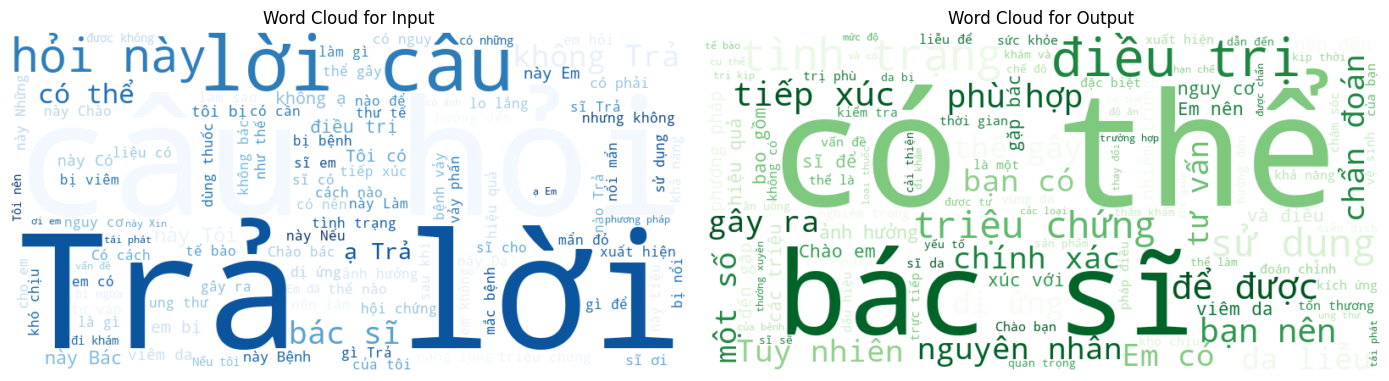

In [21]:
plot_wordclouds_for_input_output(df)

# Save dataset

In [22]:
# Save
train_df.to_csv("data_train.csv",index=False)
valid_df.to_csv("data_valid.csv",index=False)
test_df.to_csv("data_test.csv",index=False)